<a href="https://colab.research.google.com/github/Rabidhau/Dev-backend/blob/main/Copy_of_ImageClassification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* The dataset is for Multi-Class, Single image classification. The pictures are
of 38 hand signs and are divided into 38 different classes.
Each Class corresponds to each alphabet in Bengali sign Language.

* There are total 11,059 images in the dataset including corrupt images , whereas 10,072 after removing the corrupt images.

* The distribution of image is around 270-285 accross different classes.

* The dataset is splitted 80% % for training, 20 % for validation and 5 % for testing from the validation.

* The preprocessing techniques applied are normalization, data augmentation, resizing etc.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import zipfile
with zipfile.ZipFile('/content/Train.zip','r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
num_skipped = 0
for folder_name in ("Train",):
    folder_path = os.path.join("/content", folder_name)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        for fname in os.listdir(subfolder_path):
            fpath = os.path.join(subfolder_path, fname)
            try:
                with open(fpath, "rb") as fobj:
                    is_jfif = b"JFIF" in fobj.peek(10)
            except Exception as e:
                is_jfif = False

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)

print(f"Deleted {num_skipped} corrupted images.")


Deleted 266 corrupted images.


In [ ]:
class_names = sorted([d for d in os.listdir("/content/Train")
 if os.path.isdir(os.path.join("/content/Train", d))])

# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
 class_path = os.path.join("/content/Train", class_name)
 if os.path.isdir(class_path):
   images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
   class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
 print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
0                                    286
1                                    287
10                                   291
11                                   284
12                                   277
13                                   279
14                                   270
15                                   287
16                                   291
17                                   286
18                                   287
19                                   288
2                                    291
20                                   286
21                                   286
22                                   293
23                                   285
24                                   290
25                                   287
26                                   285
27                                   286
28                                   284
29                                

In [ ]:
from PIL import Image
import os

image_folder = "/content/Train"
sizes = set()
# check if resizing needs to be done or not
for root, dirs, files in os.walk(image_folder):
    for filename in files:
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, filename)
            img = Image.open(img_path)
            sizes.add(img.size)

print(sizes)

{(224, 224)}


In [ ]:
# Hyper-parameters:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Train",
     validation_split=0.25,
      subset="training",
      seed=1337,
      image_size=(img_height, img_width),
      batch_size=batch_size
  )

Found 10792 files belonging to 38 classes.
Using 8094 files for training.


In [ ]:
# Printing out number of Classes
class_names = train_ds.class_names
print(class_names)
print(f"Total number of classes: {len(class_names)}")

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']
Total number of classes: 38


In [ ]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/Train",
        validation_split=0.20,
        subset="validation",
        seed=1337,
        image_size=(img_height, img_width),
        batch_size=batch_size
  )

Found 10792 files belonging to 38 classes.
Using 2158 files for validation.


In [ ]:
# split val_test_ds into validation and test datasets
val_batches = int(0.8 * len(val_test_ds))  # 80% for validation, 20% for test
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

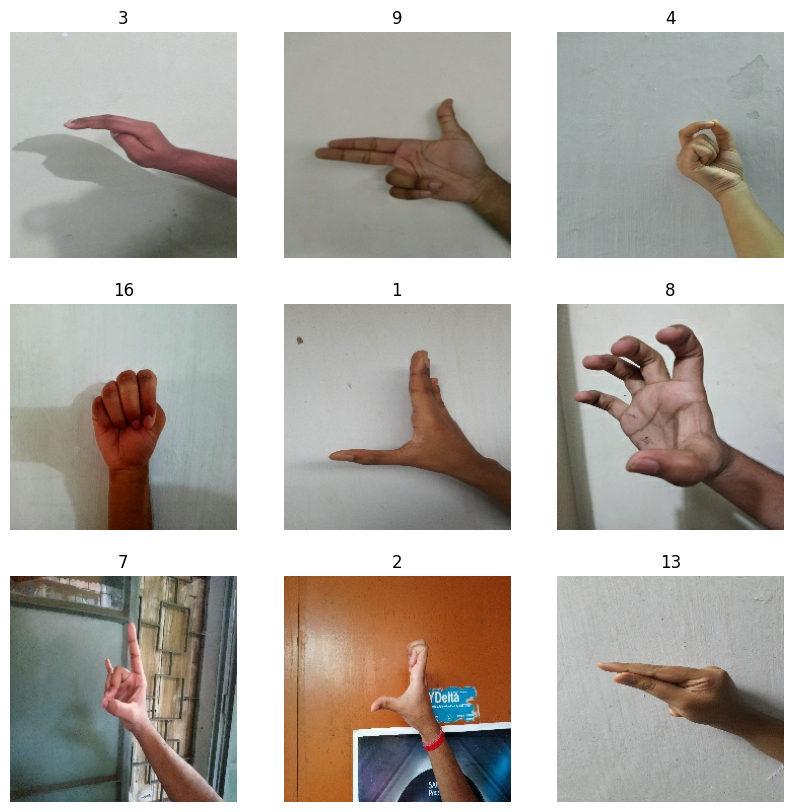

In [ ]:
# sample visualization of first 9 images in dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Sample augmented images :

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

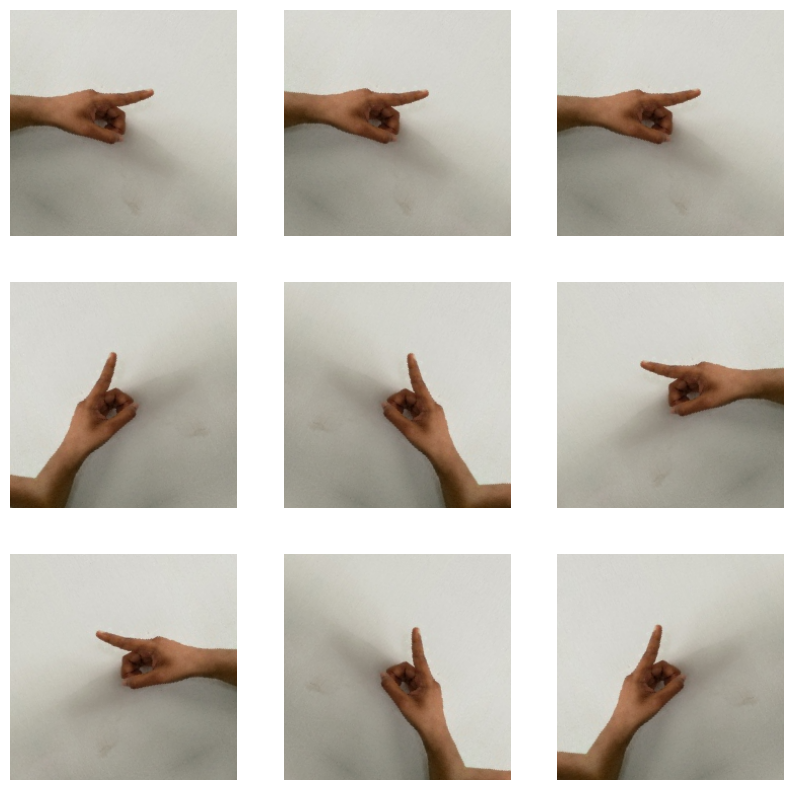

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# **Base Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def generate_basemodel(image_height, image_width, nchannels, num_classes):
    """
    This function will generate a model with a set of hyperparameters defined above.
    Input Args:
    image_height[int] = Height of an image.
    image_width[int] = Width of an image.
    nchannels[int] = Number of channels in image.
    num_classes[int] = Number of classes in dataset.
    Output Args:
    model -> A CNN model.
    """
    base_model = tf.keras.Sequential([
        # Input Layer
        layers.Input(shape=(image_height, image_width, nchannels)),

        # Rescaling
        layers.Rescaling(1./255),

        # First Block of Convolution: 16 filters (small features) and Pooling Operations.
        layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Second Block of Convolution: 24 filters (more complex features) and Pooling Operations.
        layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Third Block of Convolution: 32 filters (even more complex features) and Pooling Operations.
        layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Flatten and Fully connected classifier
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),

        # Output layer
        layers.Dense(num_classes, activation="softmax")  # num_classes corresponds to the number of output classes
    ])

    return base_model

In [ ]:
num_classes = len(class_names)
base_model = generate_basemodel(224, 224, 3, 38)

In [ ]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         1,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,950,022 (49.40 MB)

 Trainable params: 12,950,022 (49.40 MB)

 Non-trainable params: 0 (0.00 B)

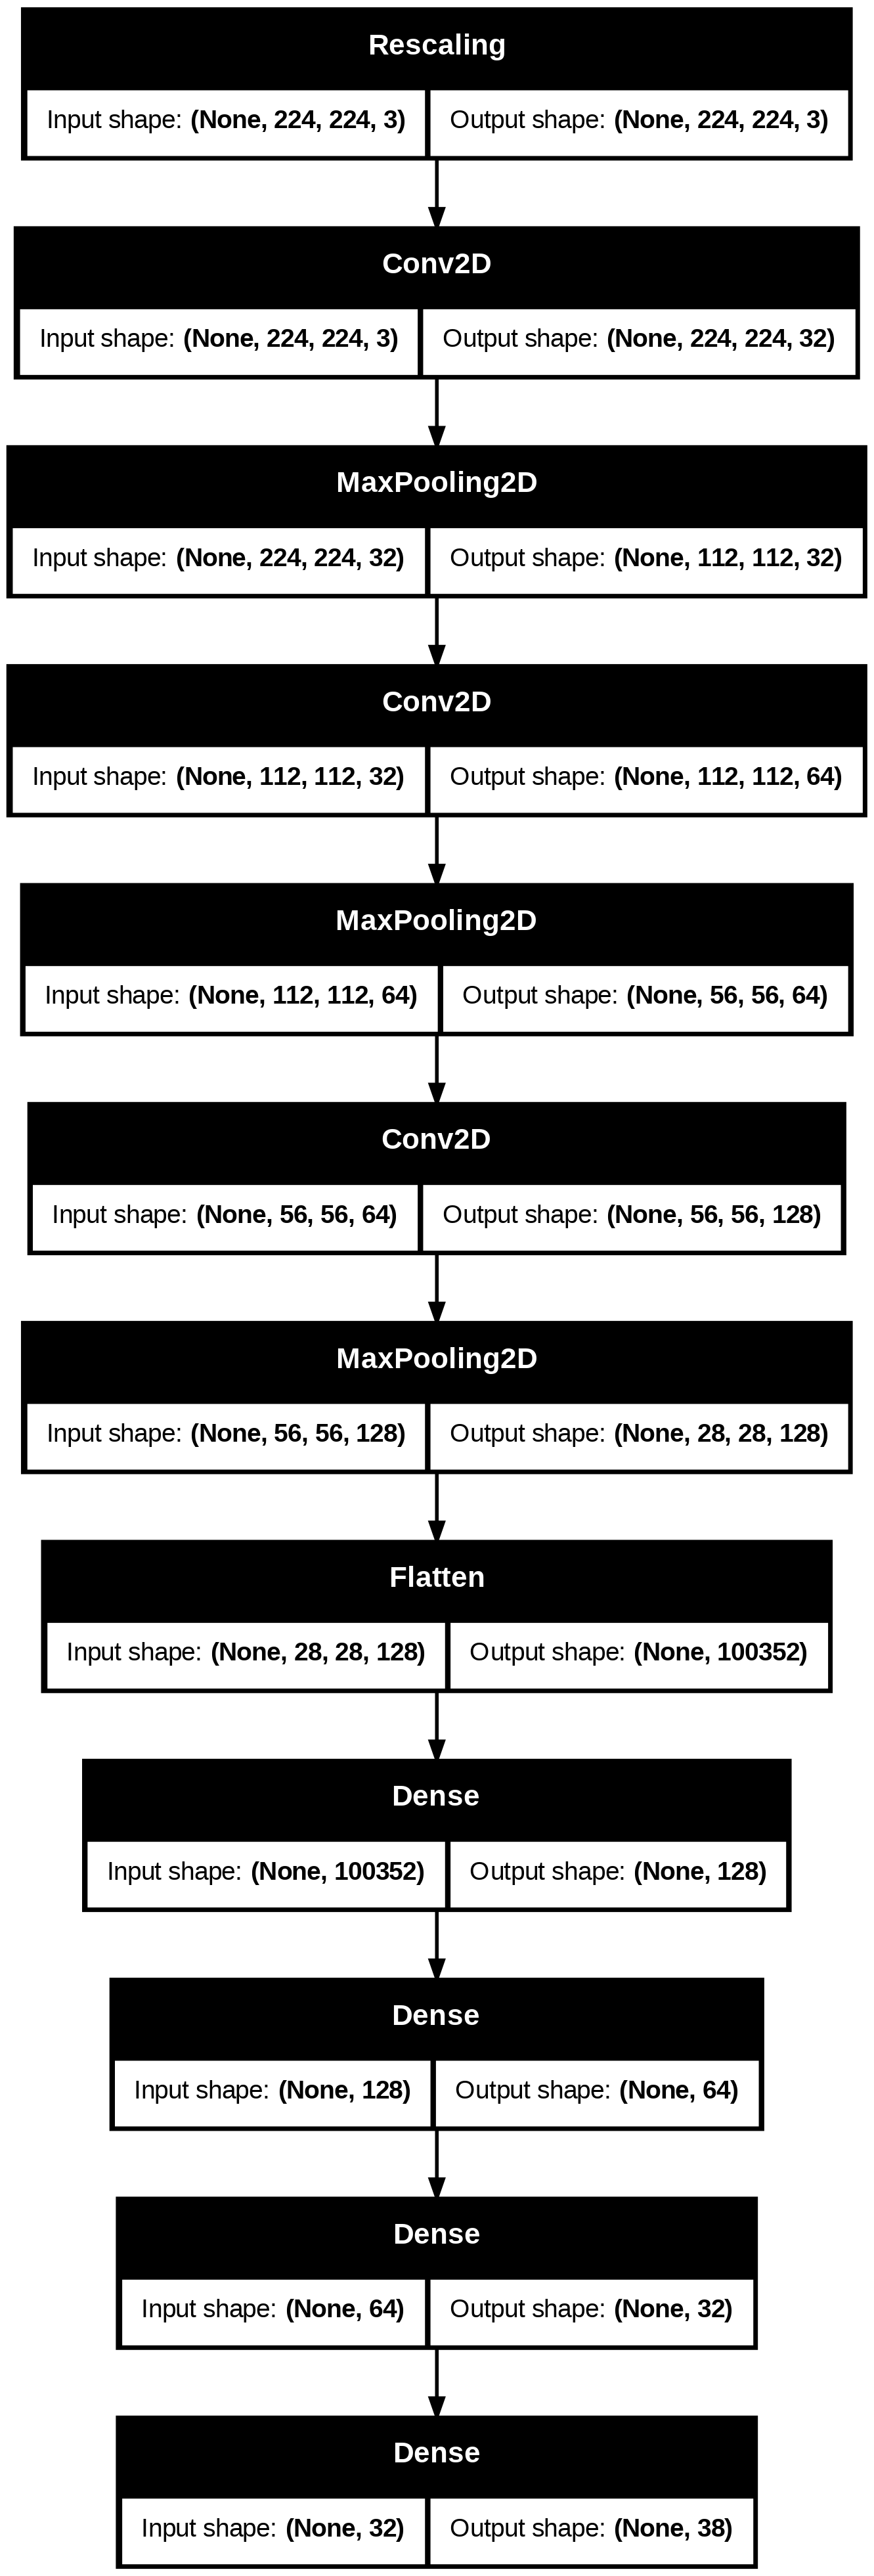

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

base_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Base model time
start_time = time.time()
history_base = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)
baseline_time = time.time() - start_time
print(f"Base model training time: {baseline_time:.2f} seconds")

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.0261 - loss: 3.6523 - val_accuracy: 0.0341 - val_loss: 3.6378
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.0550 - loss: 3.5601 - val_accuracy: 0.1887 - val_loss: 2.9665
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.2244 - loss: 2.7725 - val_accuracy: 0.3333 - val_loss: 2.2281
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.4243 - loss: 1.9260 - val_accuracy: 0.4659 - val_loss: 1.7914
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.5979 - loss: 1.2767 - val_accuracy: 0.5150 - val_loss: 1.8190
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7107 - loss: 0.8825 - val_accuracy: 0.5174 - val_loss: 2.0384
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8113 - loss: 0.5984 - val_accuracy: 0.5208 - val_loss: 2.3411
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8518 - loss: 0.4531 - 

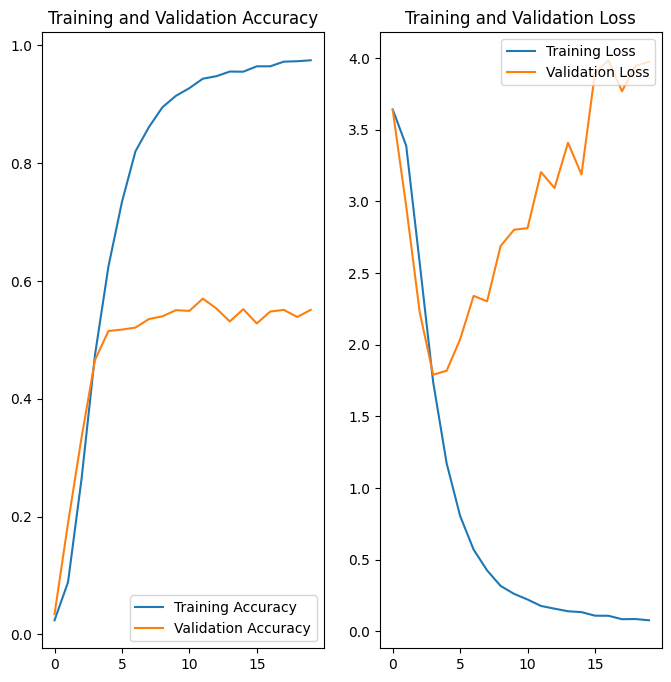

In [ ]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names = val_test_ds.class_names

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

y_true = []
y_pred1 = []

for images, labels in val_test_ds:
    preds = base_model.predict(images)

    # If multi-class (e.g., softmax output)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred1.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

              precision    recall  f1-score   support

           0       0.60      0.54      0.57        59
           1       0.84      0.62      0.71        60
          10       0.64      0.55      0.59        71
          11       0.69      0.76      0.72        58
          12       0.53      0.31      0.39        58
          13       0.30      0.37      0.33        43
          14       0.39      0.39      0.39        49
          15       0.38      0.42      0.40        55
          16       0.51      0.53      0.52        62
          17       0.65      0.61      0.63        71
          18       0.40      0.30      0.35        63
          19       0.47      0.44      0.45        61
           2       0.61      0.45      0.52        55
          20       0.55      0.41      0.47        51
          21       0.50      0.57      0.53        46
          22       0.56      0.52      0.54        54
          23       0.41      0.57      0.48        58
          24       0.53    

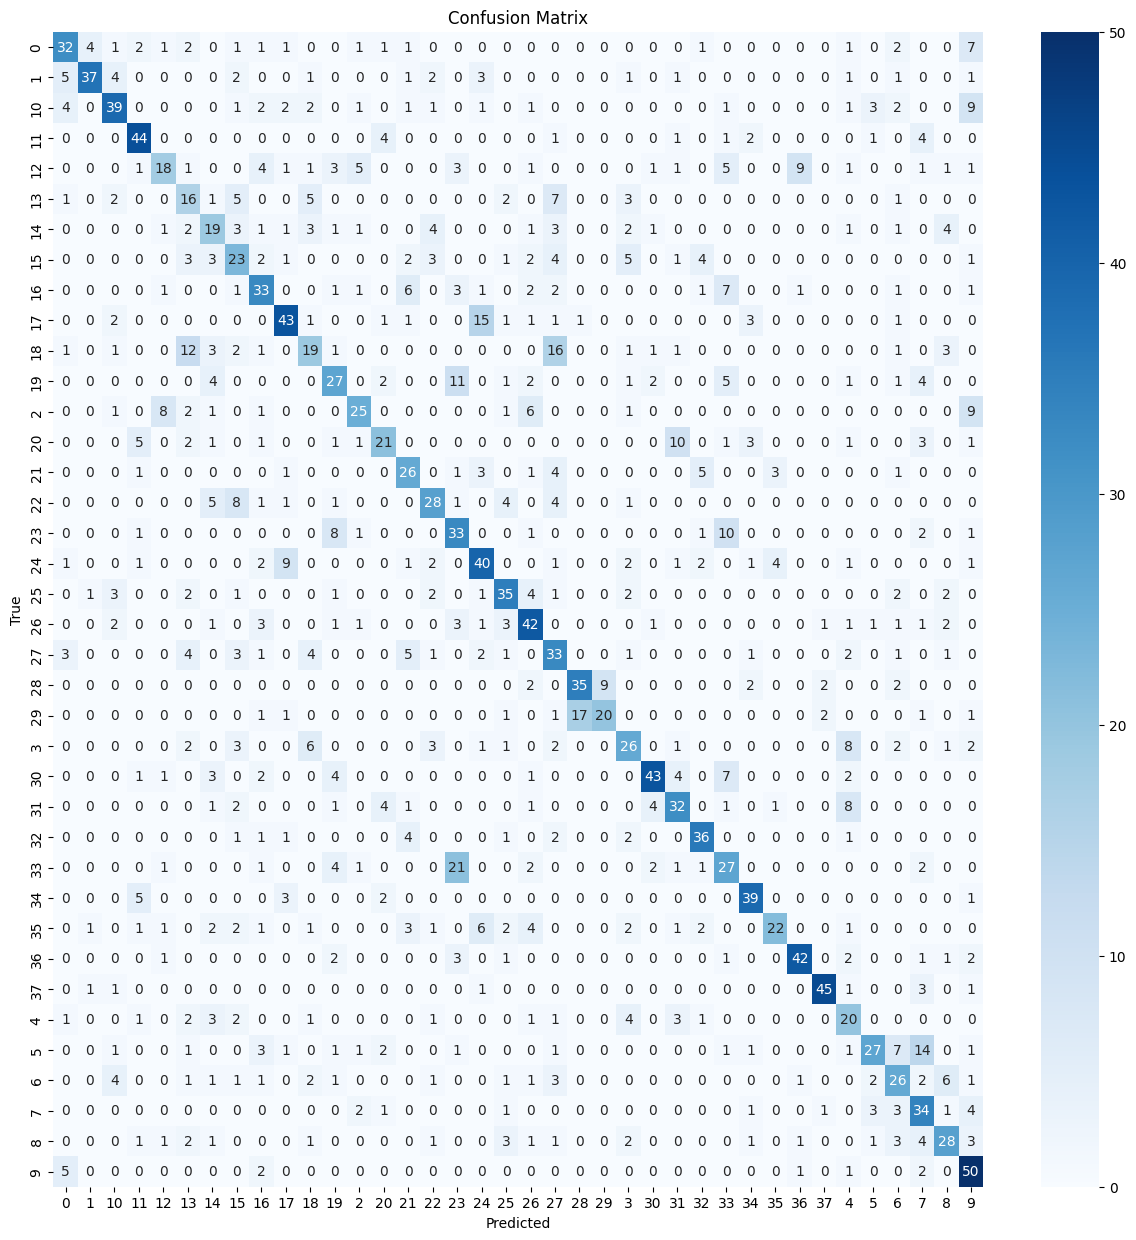

In [ ]:
print(classification_report(y_true, y_pred1, target_names=class_names))

# Compute and print confusion matrix
cm = confusion_matrix(y_true, y_pred1)


plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


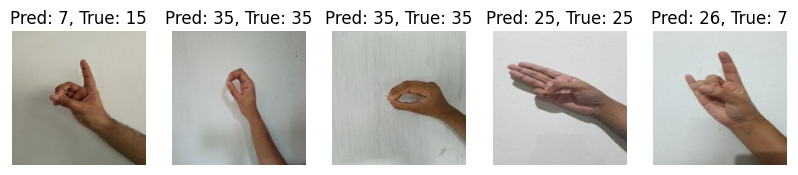

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_plot(base_model, test_ds, num_examples=5):
    # Retrieve a batch of images and labels from the test dataset
    images, labels = next(iter(test_ds))

    # Make predictions using the model
    predictions = base_model.predict(images)

    # Plot the images with their predictions and true labels
    plt.figure(figsize=(10, 10))

    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        predicted_label = np.argmax(predictions[i])  # Predicted class (highest probability)
        true_label = labels[i].numpy()  # True class label

        ax.set_title(f"Pred: {predicted_label}, True: {true_label}")
        ax.axis("off")

    plt.show()
predict_and_plot(base_model,test_ds)

Discussion about the model performance:


*   The model was overfitted as can be seen in the graph
*   Computational time was low due to less complexity of the model.



# **Optimized Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def generate_model(image_height, image_width, nchannels, num_classes):
    """
    This function will generate a model with a set of hyperparameters defined above.
    Input Args:
    image_height[int] = Height of an image.
    image_width[int] = Width of an image.
    nchannels[int] = Number of channels in image.
    num_classes[int] = Number of classes in dataset.
    Output Args:
    model -> A CNN model.
    """
    model = tf.keras.Sequential([
        # Input Layer
        layers.InputLayer(shape=(image_height, image_width, nchannels)),

        # Data Augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.1),

        # Rescaling
        layers.Rescaling(1./255),

        # First Block of Convolution: 16 filters (small features) and Pooling Operations.
        layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.BatchNormalization(),

        # Second Block of Convolution: 24 filters (more complex features) and Pooling Operations.
        layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.BatchNormalization(),

        # Third Block of Convolution: 32 filters (even more complex features) and Pooling Operations.
        layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.BatchNormalization(),

        # Flatten and Fully connected classifier
        layers.GlobalAveragePooling2D(),# instead of flatten as its better for medium datasets
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),

        # Output layer
        layers.Dense(num_classes, activation="softmax")  # num_classes corresponds to the number of output classes
    ])

    return model

In [ ]:
model_sgd=generate_model(224, 224, 3, 38)

In [ ]:
model = generate_model(224, 224, 3, 38)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,318 (1.26 MB)

 Trainable params: 328,870 (1.25 MB)

 Non-trainable params: 448 (1.75 KB)

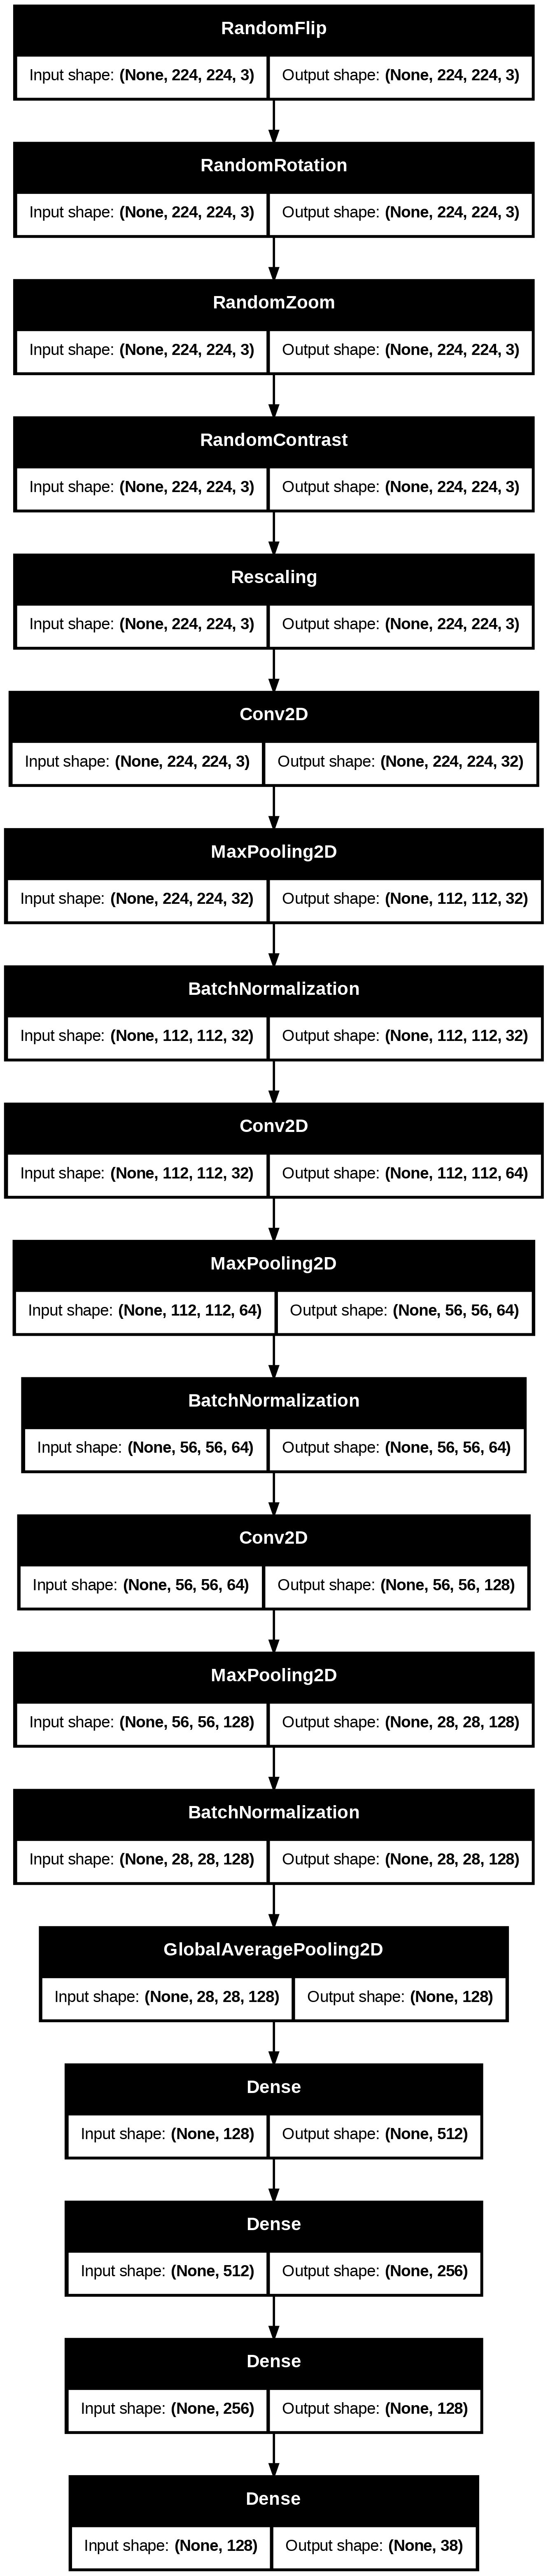

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import SGD

model_sgd.compile(loss="sparse_categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
epochs = 25
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4,verbose=1)
]
# Optimized model
start_time = time.time()
history_sdg = model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)
new_model_time_sgd = time.time() - start_time
print(f"New model training time: {new_model_time_sgd:.2f} seconds")

Epoch 1/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.0298 - loss: 3.6439 - val_accuracy: 0.0278 - val_loss: 3.6422 - learning_rate: 0.0100
Epoch 2/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.0454 - loss: 3.6303 - val_accuracy: 0.0307 - val_loss: 3.6339 - learning_rate: 0.0100
Epoch 3/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.0457 - loss: 3.6222 - val_accuracy: 0.0417 - val_loss: 3.6374 - learning_rate: 0.0100
Epoch 4/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.0507 - loss: 3.6154 - val_accuracy: 0.0480 - val_loss: 3.6361 - learning_rate: 0.0100
Epoch 5/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.0484 - loss: 3.6089 - val_accuracy: 0.0509 - val_loss: 3.6332 - learning_rate: 0.0100
Epoch 6/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.0512 - loss: 3.6007 - val_accuracy: 0.0428 - val_loss: 3.6288 - learning_rate: 0.0100
Epoch 7/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.0557 - l

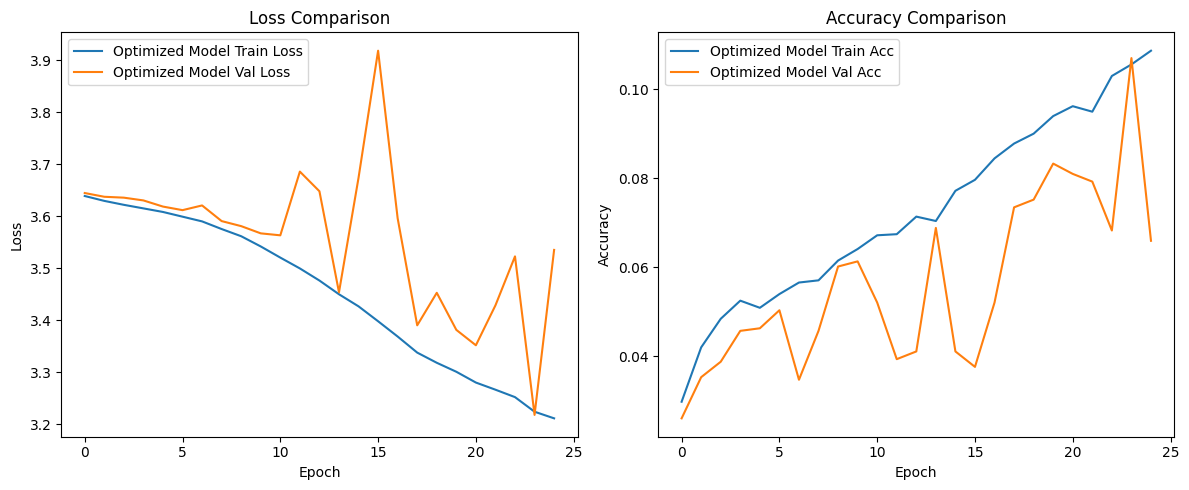

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_sdg.history['loss'], label='Optimized Model Train Loss')
plt.plot(history_sdg.history['val_loss'], label='Optimized Model Val Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy (optional)
plt.subplot(1, 2, 2)
plt.plot(history_sdg.history['accuracy'], label='Optimized Model Train Acc')
plt.plot(history_sdg.history['val_accuracy'], label='Optimized Model Val Acc')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#model.compile(optimizer=keras.optimizers.Adam(1e-4),  # Very low learning rate loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
epochs = 25
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4,verbose=1)
]
# Optimized model
start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)
new_model_time = time.time() - start_time
print(f"New model training time: {new_model_time:.2f} seconds")

Epoch 1/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.0350 - loss: 3.6383 - val_accuracy: 0.0249 - val_loss: 4.5507 - learning_rate: 0.0010
Epoch 2/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.0594 - loss: 3.5472 - val_accuracy: 0.0237 - val_loss: 6.1012 - learning_rate: 0.0010
Epoch 3/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.0771 - loss: 3.4051 - val_accuracy: 0.0255 - val_loss: 3.7583 - learning_rate: 0.0010
Epoch 4/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.1346 - loss: 3.0704 - val_accuracy: 0.1059 - val_loss: 3.2632 - learning_rate: 0.0010
Epoch 5/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.2018 - loss: 2.7021 - val_accuracy: 0.1209 - val_loss: 3.7346 - learning_rate: 0.0010
Epoch 6/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.2818 - loss: 2.3031 - val_accuracy: 0.1719 - val_loss: 3.3531 - learning_rate: 0.0010
Epoch 7/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.3502 - l

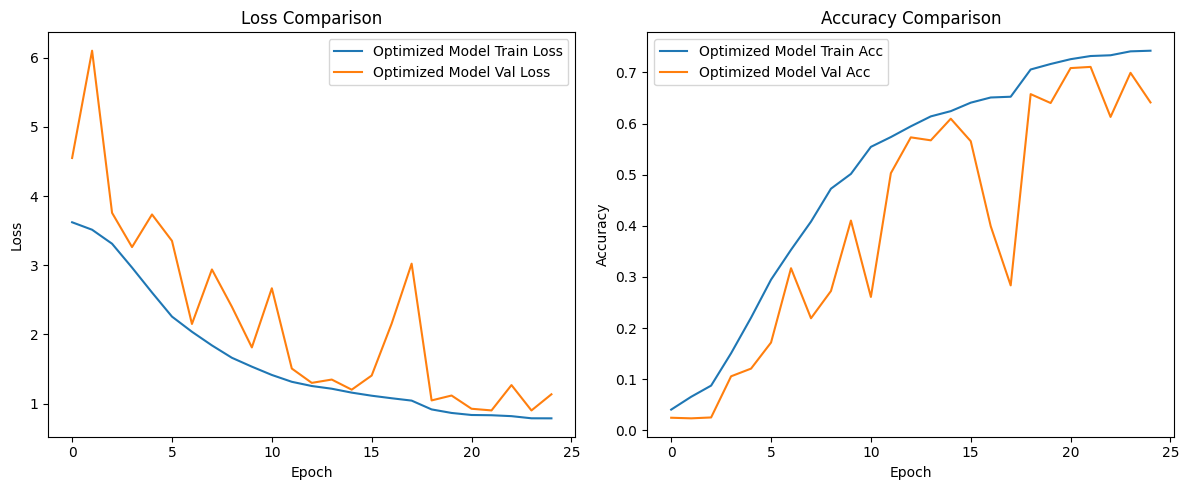

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Optimized Model Train Loss')
plt.plot(history.history['val_loss'], label='Optimized Model Val Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy (optional)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Optimized Model Train Acc')
plt.plot(history.history['val_accuracy'], label='Optimized Model Val Acc')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


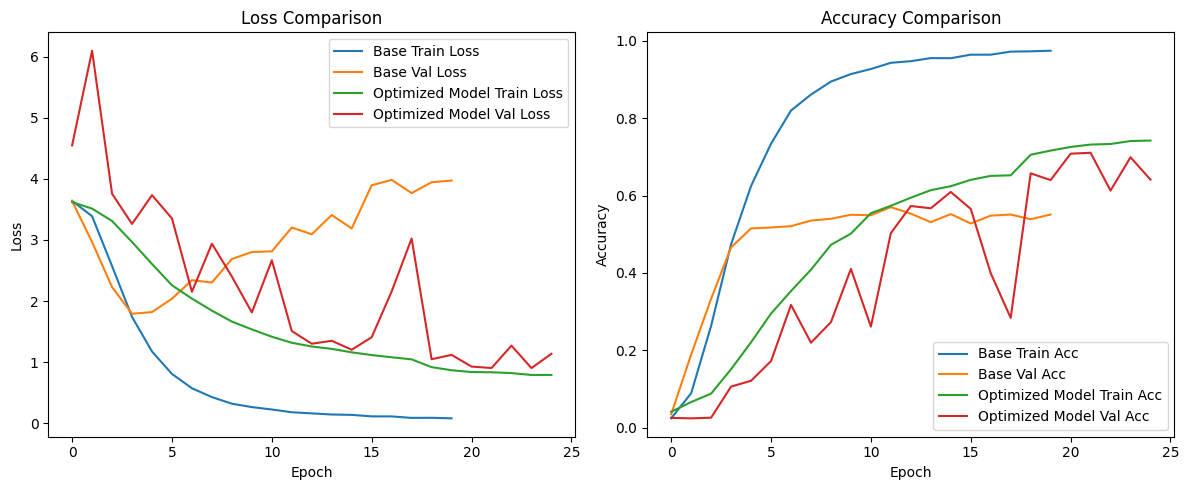

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_base.history["loss"], label='Base Train Loss')
plt.plot(history_base.history["val_loss"], label='Base Val Loss')
plt.plot(history.history['loss'], label='Optimized Model Train Loss')
plt.plot(history.history['val_loss'], label='Optimized Model Val Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy (optional)
plt.subplot(1, 2, 2)
plt.plot(history_base.history['accuracy'], label='Base Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Base Val Acc')
plt.plot(history.history['accuracy'], label='Optimized Model Train Acc')
plt.plot(history.history['val_accuracy'], label='Optimized Model Val Acc')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


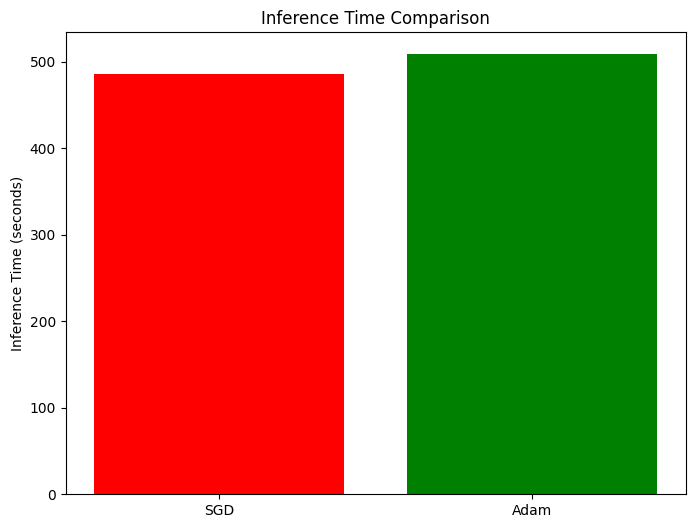

In [ ]:
# Plot Inference Time Bar Graph
models = ['SGD', 'Adam']
inference_times = [new_model_time_sgd,new_model_time]

plt.figure(figsize=(8, 6))
plt.bar(models, inference_times, color=['red', 'green'])
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

y_true = []
y_pred2 = []

for images, labels in val_test_ds:
    preds = model.predict(images)

    # If multi-class (e.g., softmax output)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred2.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

              precision    recall  f1-score   support

           0       0.60      0.41      0.48        59
           1       0.82      0.75      0.78        60
          10       0.78      0.51      0.62        71
          11       0.71      0.83      0.76        58
          12       0.80      0.71      0.75        58
          13       0.70      0.53      0.61        43
          14       0.60      0.67      0.63        49
          15       0.71      0.67      0.69        55
          16       0.94      0.81      0.87        62
          17       0.79      0.87      0.83        71
          18       0.58      0.78      0.67        63
          19       0.72      0.70      0.71        61
           2       0.72      0.78      0.75        55
          20       0.78      0.75      0.76        51
          21       0.66      0.83      0.73        46
          22       0.74      0.65      0.69        54
          23       0.46      0.76      0.57        58
          24       0.75    

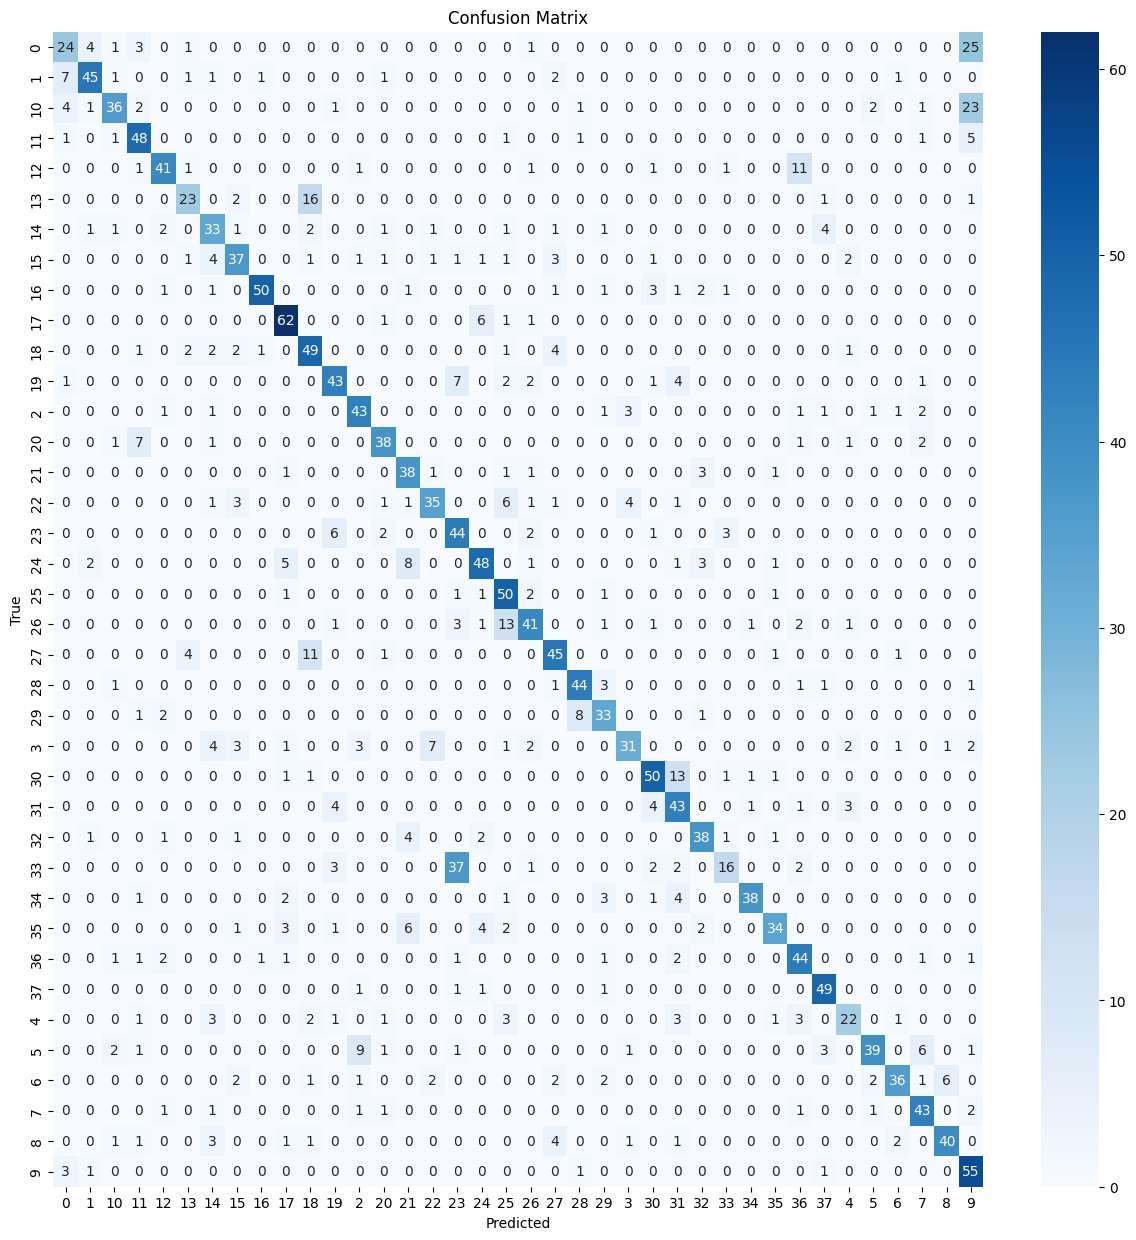

In [ ]:
print(classification_report(y_true, y_pred2, target_names=class_names))

# Compute and print confusion matrix
cm = confusion_matrix(y_true, y_pred2)


plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


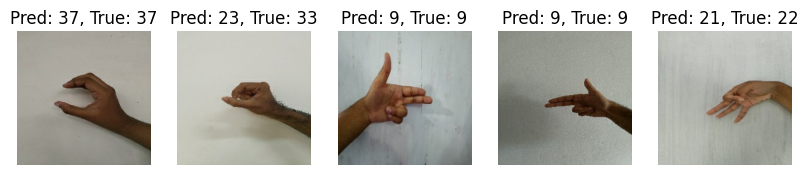

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_plot(model, test_ds, num_examples=5):
    # Retrieve a batch of images and labels from the test dataset
    images, labels = next(iter(test_ds))

    # Make predictions using the model
    predictions = model.predict(images)

    # Plot the images with their predictions and true labels
    plt.figure(figsize=(10, 10))

    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        predicted_label = np.argmax(predictions[i])  # Predicted class (highest probability)
        true_label = labels[i].numpy()  # True class label

        ax.set_title(f"Pred: {predicted_label}, True: {true_label}")
        ax.axis("off")

    plt.show()
predict_and_plot(model,test_ds)

Discussion on improvements compared to the baseline model:


*   The optmized model worked better than that of base model due to some reguralization techiniques and showed better result while using Adam optimizer
*   Computational time was increased significantly because of the complexity ut had a better result.



In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the ImageDataGenerator
datagen = ImageDataGenerator(
          rescale=1./255,    # Normalize pixel values
          rotation_range=20,  # Random rotation (±20 %)
          horizontal_flip=True,   # Random horizontal flip
          vertical_flip=True,    # Random vertical flip
          brightness_range=[0.8, 1.2], # Random brightness adjustment
          validation_split=0.2 )

# Load the images and resize them using target_size
train_data = datagen.flow_from_directory(
    '/content/Train',
    target_size=(224,224),  # Resize images to 224*224
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_data = datagen.flow_from_directory(
    '/content/Train',
    target_size=(224,224),  # Resize images to 224*224
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

# Load base model without top layers
pre_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_model.trainable = False  # Initially freeze base

#custom classification head
x = pre_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(38, activation='softmax')(x)  # 38 classes

model_3 = Model(inputs=pre_model.input, outputs=output)
#optimizer = SGD(learning_rate=1e-3, momentum=0.9)
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]
model_3.fit(train_data, callbacks=callbacks, validation_data=val_data, epochs=30)

Found 8648 images belonging to 38 classes.
Found 2144 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 173s 624ms/step - accuracy: 0.0261 - loss: 3.7944 - val_accuracy: 0.0965 - val_loss: 3.5772 - learning_rate: 0.0010
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 167s 616ms/step - accuracy: 0.0621 - loss: 3.5532 - val_accuracy: 0.1507 - val_loss: 3.2948 - learning_rate: 0.0010
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 168s 619ms/step - accuracy: 0.1130 - loss: 3.2986 - val_accuracy: 0.1819 - val_loss: 2.9475 - learning_rate: 0.0010
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 203s 622ms/step - accuracy: 0.1481 - loss: 3.0622 - val_accuracy: 0.3358 - val_loss: 2.6892 - learning_rate: 0.0010
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 168s 619ms/step - accuracy: 0.1869 - loss: 2.8886 - val_accuracy: 0.2850 - val_loss: 2.5962 - learning_rate: 0.0010
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 166s 612ms/step - accuracy: 0.2067 - loss: 2.7714 - val_accuracy: 0.3256 - val_loss: 2.4389 - learning_rate: 0.0010
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 168s 619ms/step - accura

In [ ]:
model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,870,836 (79.62 MB)

 Trainable params: 282,150 (1.08 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 564,302 (2.15 MB)

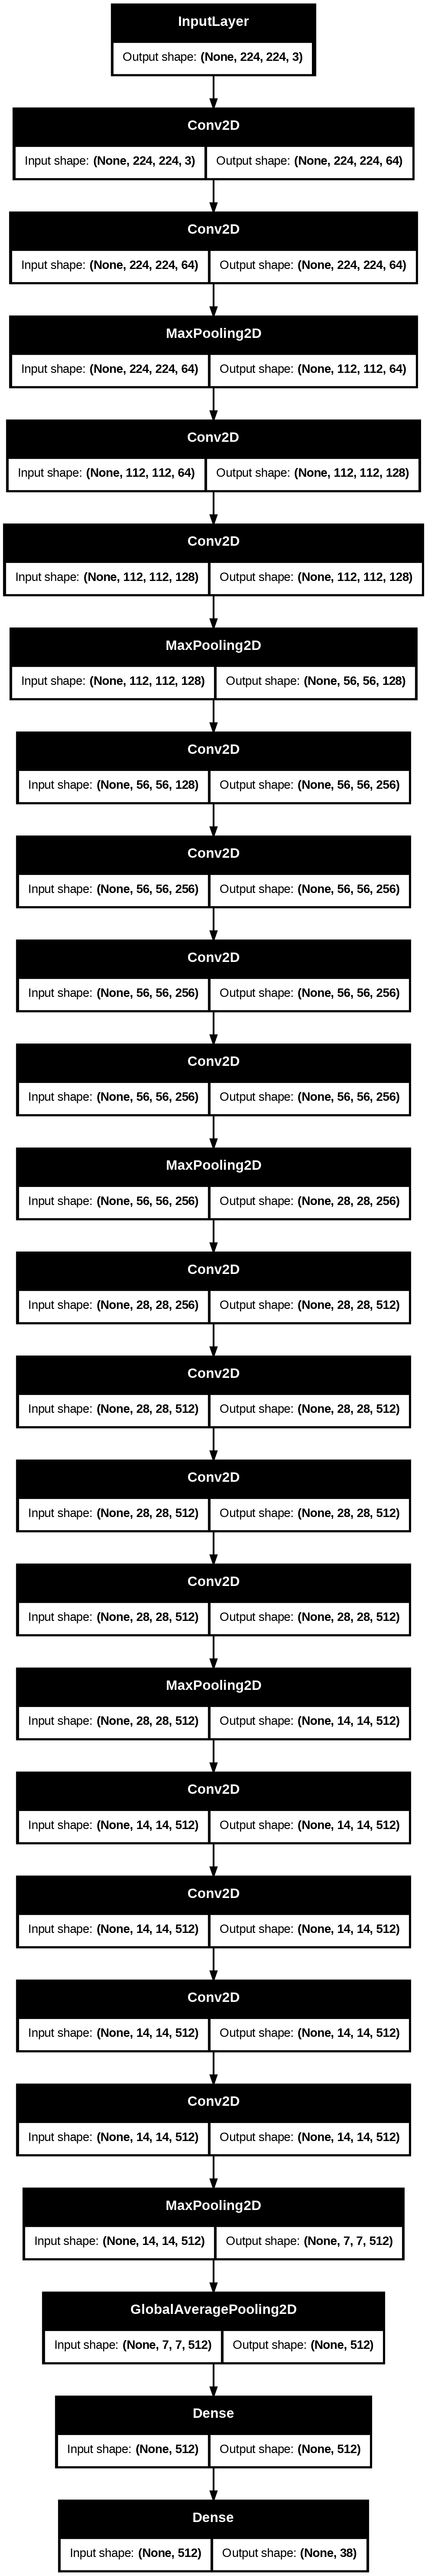

In [ ]:
keras.utils.plot_model(model_3, show_shapes=True)

In [ ]:
start_time = time.time()
# Unfreeze last 4 convolutional block
for layer in pre_model.layers[-4:]:
    layer.trainable = True
# Callbacks
callback = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

# Recompile with a low learning rate
model_3.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history= model_3.fit(train_data, validation_data=val_data,callbacks=callback, epochs=15)
VGG19_time = time.time() - start_time
print(f"VGG19 model training time: {VGG19_time:.2f} seconds")


Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 172s 614ms/step - accuracy: 0.7229 - loss: 0.8956 - val_accuracy: 0.6894 - val_loss: 1.0633 - learning_rate: 1.0000e-05
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 165s 609ms/step - accuracy: 0.7820 - loss: 0.6805 - val_accuracy: 0.7034 - val_loss: 0.9652 - learning_rate: 1.0000e-05
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 175s 647ms/step - accuracy: 0.8114 - loss: 0.6042 - val_accuracy: 0.7206 - val_loss: 0.9096 - learning_rate: 1.0000e-05
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 169s 624ms/step - accuracy: 0.8450 - loss: 0.4976 - val_accuracy: 0.7323 - val_loss: 0.8729 - learning_rate: 1.0000e-05
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 170s 626ms/step - accuracy: 0.8509 - loss: 0.4798 - val_accuracy: 0.7649 - val_loss: 0.8216 - learning_rate: 1.0000e-05
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 170s 626ms/step - accuracy: 0.8612 - loss: 0.4351 - val_accuracy: 0.7570 - val_loss: 0.7726 - learning_rate: 1.0000e-05
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 

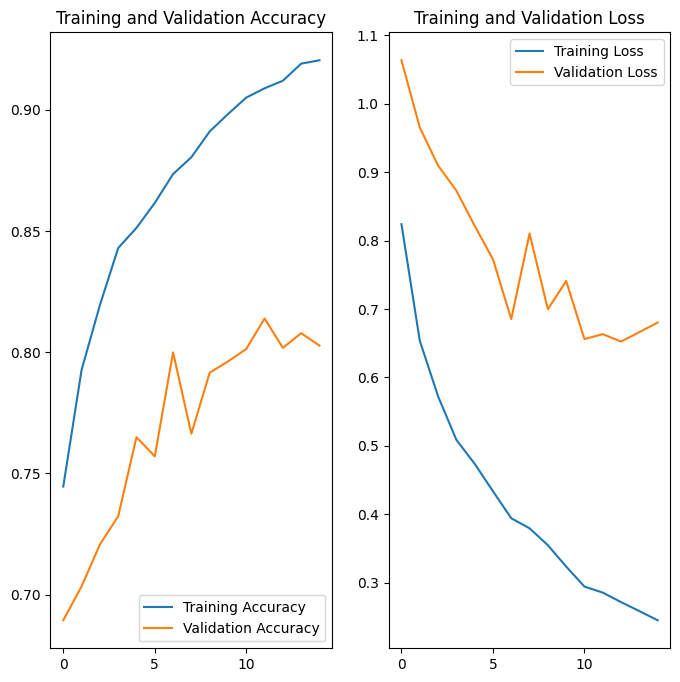

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range=range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

y_true = []
y_pred3 = []

for images, labels in val_test_ds:
    preds = model_3.predict(images)

    # If multi-class (e.g., softmax output)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred3.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

              precision    recall  f1-score   support

           0       0.55      0.69      0.62        59
           1       0.64      0.80      0.71        60
          10       0.69      0.58      0.63        71
          11       0.94      0.53      0.68        58
          12       0.71      0.64      0.67        58
          13       0.40      0.65      0.50        43
          14       0.47      0.31      0.37        49
          15       0.52      0.40      0.45        55
          16       0.45      0.82      0.58        62
          17       0.63      0.89      0.74        71
          18       0.30      0.84      0.45        63
          19       0.91      0.16      0.28        61
           2       0.56      0.84      0.67        55
          20       0.83      0.69      0.75        51
          21       0.61      0.59      0.60        46
          22       0.74      0.31      0.44        54
          23       0.56      0.69      0.62        58
          24       0.77    

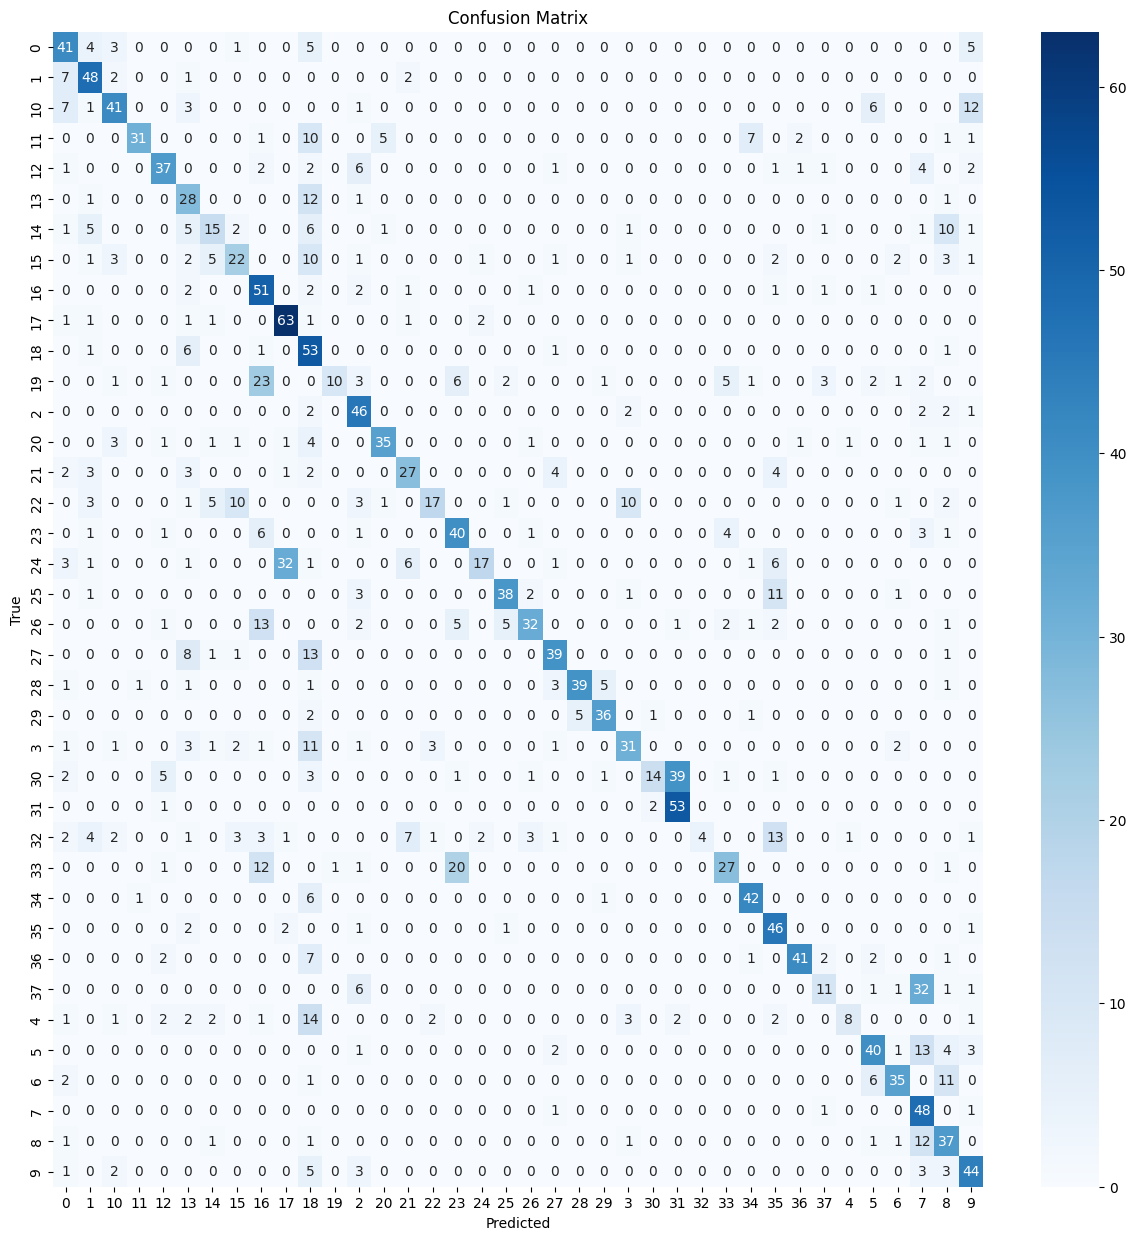

In [ ]:
print(classification_report(y_true, y_pred3, target_names=class_names))

# Compute and print confusion matrix
cm = confusion_matrix(y_true, y_pred3)


plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


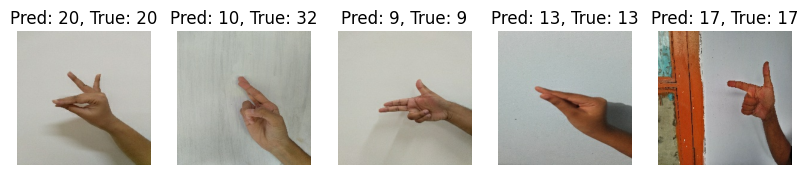

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_plot(model_3, test_ds, num_examples=5):
    # Retrieve a batch of images and labels from the test dataset
    images, labels = next(iter(test_ds))

    # Make predictions using the model
    predictions = model_3.predict(images)

    # Plot the images with their predictions and true labels
    plt.figure(figsize=(10, 10))

    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        predicted_label = np.argmax(predictions[i])  # Predicted class (highest probability)
        true_label = labels[i].numpy()  # True class label

        ax.set_title(f"Pred: {predicted_label}, True: {true_label}")
        ax.axis("off")

    plt.show()
predict_and_plot(model_3,test_ds)

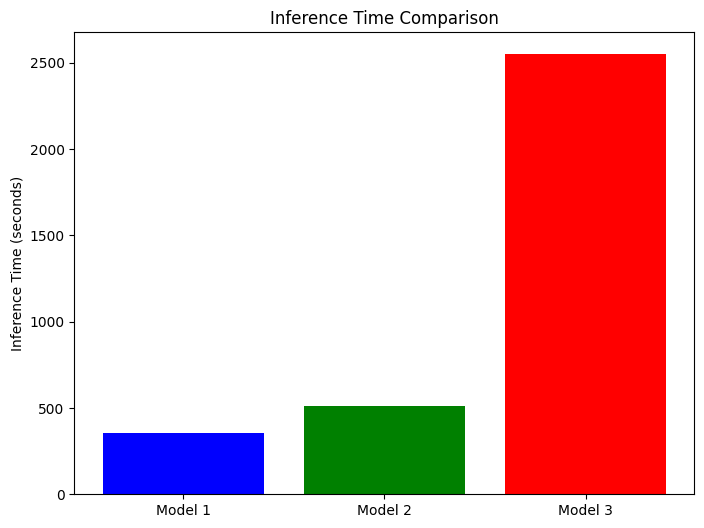

In [ ]:
# Plot Inference Time Bar Graph
models = ['Model 1', 'Model 2', 'Model 3']
inference_times = [baseline_time,new_model_time,VGG19_time]

plt.figure(figsize=(8, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'red'])
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.show()

In [ ]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

In [ ]:
from sklearn.preprocessing import label_binarize

n_classes = 38
classes = list(range(n_classes))  # 0 to 37

# Step 1: One-hot encode true labels
y_true_bin = label_binarize(y_true, classes=classes)

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

def compute_roc_auc(y_true_bin, y_probs, n_classes):
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    return fpr, tpr, roc_auc

In [ ]:
# prediction probabilities
y_prob1 = base_model.predict(test_ds)
y_prob2 = model.predict(test_ds)
y_prob3 = model_3.predict(test_ds)

# call function
fpr1, tpr1, auc1 = compute_roc_auc(y_true_bin, y_prob1, n_classes)
fpr2, tpr2, auc2 = compute_roc_auc(y_true_bin, y_prob2, n_classes)
fpr3, tpr3, auc3 = compute_roc_auc(y_true_bin, y_prob3, n_classes)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step


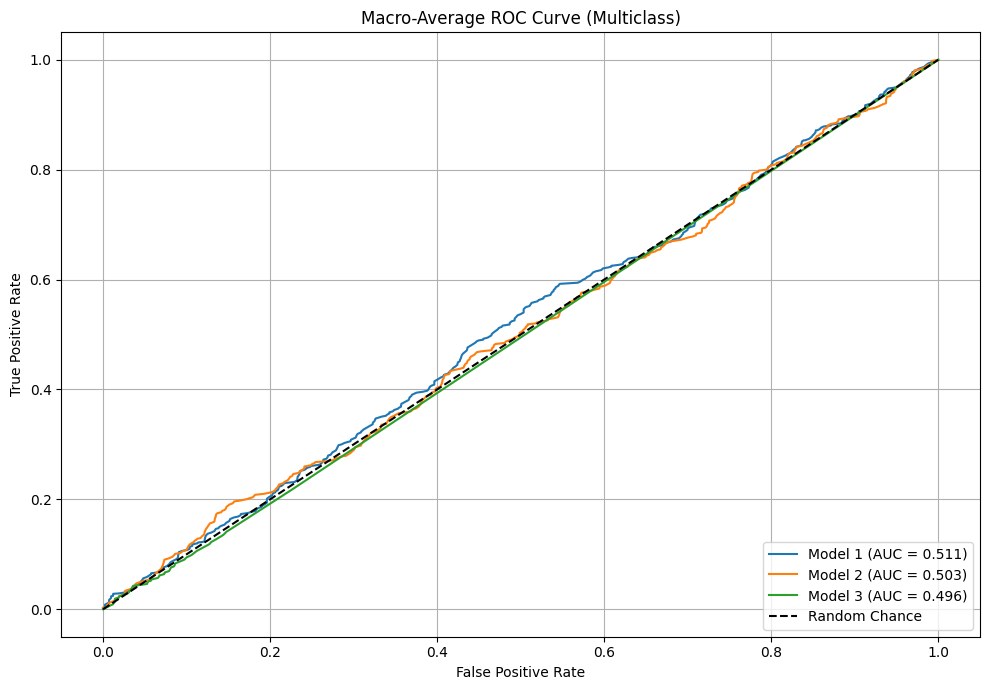

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(fpr1["macro"], tpr1["macro"], label=f'Model 1 (AUC = {auc1["macro"]:.3f})')
plt.plot(fpr2["macro"], tpr2["macro"], label=f'Model 2 (AUC = {auc2["macro"]:.3f})')
plt.plot(fpr3["macro"], tpr3["macro"], label=f'Model 3 (AUC = {auc3["macro"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curve (Multiclass)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()